In [1]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
data = pd.read_csv('forestfires.csv')

In [43]:
data['area'].mean()

12.847292069632491

### Сделаем преобразования над данными

заменим координату month на индикатор летнего сезона

удалим координату day 

In [44]:
data['month'] = data.month.apply(lambda x: float(x == 'aug' or x == 'jul' 
                                                 or x == 'jun'))

data.drop('day',axis=1,inplace=True)

приведем все значения к float,чтобы не было проблем с матричными операциями

In [45]:
data['X'] = data.X.apply(lambda x: float(x))
data['Y'] = data.Y.apply(lambda x: float(x))
data['RH'] = data.RH.apply(lambda x: float(x))

добавим координату, тождественно равную единице. Она будет отвечать свободному члену в линейной коомбинации

In [46]:
data['free_member'] = 1.0

In [47]:
area = data['area']
data.drop('area', axis = 1, inplace = True)
data['area'] = area
new_data = data.as_matrix()
random.shuffle(new_data) # перемешаем выборку

### Строим регрессионную модель

$ \hat{\theta} = (Z^TZ)^{-1}Z^TX$

In [48]:
area = (new_data.T[-1]).T # выбираем столбец area
data = (new_data.T[:-1]).T # data- матрица без столбца area

Z = np.matrix(data[:len(data)/10*7]) # разделяем выборку на две части
Z_2 = np.matrix(data[len(Z):])
X = np.matrix(area[:len(data)/10*7]).T
X_2 = np.matrix(area[len(X):]).T

estimation = ((Z.T * Z).I) * Z.T * X

### Среднеквадратичная ошибка

In [49]:
error = np.std(Z_2 * estimation - X_2)
print 'Среднеквадратичная ошибка', error

Среднеквадратичная ошибка 24.9229531914


Как видно среднеквадратичная ошибка 23.55 достаточно большая, учитывая, что в среднем area принимает значение 12.85

### Сделаем для area преобразование f(x) = ln(c+x) и построим для нее регрессионную модель


In [50]:
def count_error(c):
    area = (new_data.T[-1]).T # выбираем столбец area
    data = (new_data.T[:-1]).T # data- матрица без столбца area
    
    Z = np.matrix(data[:len(data)/10*7])
    Z_2 = np.matrix(data[len(Z):])
    X_log = np.log(np.matrix(area[:len(data)/10*7]).T + c)
    X_2 = np.log(np.matrix(area[len(Z):]).T + c)


    estimation = (Z.T * Z).I * Z.T * X_log
    predictions = Z_2 * estimation
    
    # cреднеквадратичная ошибка для преобразованных значений
    error = np.std(predictions - X_2)
  
    inv_predictions = np.exp(predictions) - c 
    # среднеквадратичная ошибка для исходных значений
    inv_error = np.std(inv_predictions - (np.exp(X_2) - c))
    return (error,inv_error)

#### Посмотрим как ведет себя ошибка при увеличении с

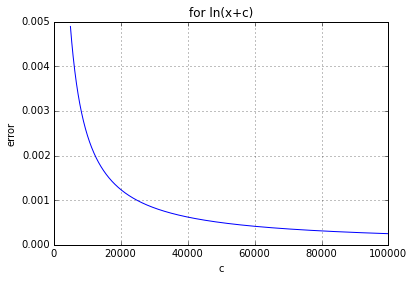

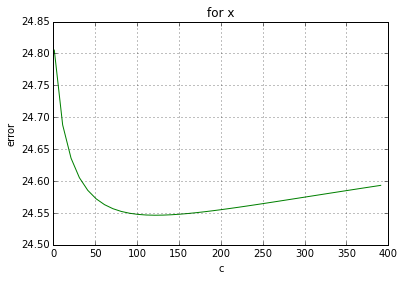

In [51]:
grid = np.arange(5000, 100000, 100)
error = [count_error(x)[0] for x in grid]
plt.plot(grid, error)
plt.xlabel('c')
plt.ylabel('error')
plt.title('for ln(x+c)')
plt.grid(True)
plt.show()

grid = np.arange(1, 400, 10)
error = [count_error(x)[1] for x in grid]
plt.plot(grid, error, color = 'green')
plt.xlabel('c')
plt.ylabel('error')
plt.title('for x')
plt.grid(True)
plt.show()

Из графиков можно увидеть, что при увеличении $c$ среднеквадратичная ошибка $ln(x+c)$ уменьшается

Однако ошибка по исходной выборке начиная $c \approx 70 $  начинает увеличиваться 


In [52]:
max_error = 0
mid_error = 0
min_error = np.inf
c = 70 # берем самое оптимальное, исходя из графиков
for i in range(5):
    random.shuffle(new_data)# перемешаем выборку        
    res = count_error(5)[1]
    
    max_error = max(max_error,res)
    min_error = min(min_error,res)
    mid_error += res
    
mid_error /= 100

print('max_error = '+ str(max_error) + '\nmid_error = ' +  str(mid_error) +
      '\nmin_error = ' + str(min_error))

0
1
2
3
4
max_error = 87.6795892804
mid_error = 1.05577139051
min_error = 3.04883335464e-11


Из полученных данных видно,что модель не очень хорошая, потому что ошибка зависит от способа разбиения